In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import random
from plt_figure import *
from loss import contrastive_loss, triplet_loss

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [19]:
def synthesis_toydata(n_classes=10, samples_per_class=200, dim=128, 
                                 mode_spread=1.4, overlap_prob=0.1, outlier_frac=0.05):
    #1|0.2
    #1.5|0.1
    #*1.4｜0.2
    #1|0.01
    data = []
    labels = []
    
    # Create base centers randomly
    centers = torch.randn(n_classes, dim) * 5

    for c in range(n_classes):
        center = centers[c]

        # Create random positive definite covariance matrix with correlations
        A = torch.randn(dim, dim)
        # covariance matrix, symmetric positive definite
        cov = A @ A.T  
        
        # Cholesky decomposition for sampling correlated noise
        L = torch.linalg.cholesky(cov + torch.eye(dim) * 1e-3)
        
        n_in_class = samples_per_class
        for _ in range(n_in_class):
            noise = L @ torch.randn(dim)
            point = center + noise * mode_spread
            
            # Assign point to another class with some probability (overlap)
            if torch.rand(1).item() < overlap_prob:
                other_class = torch.randint(0, n_classes, (1,)).item()
                labels.append(other_class)
            else:
                labels.append(c)
            
            data.append(point)
        
    # Add uniform random outliers (background noise)
    n_outliers = int(len(data) * outlier_frac)
    for _ in range(n_outliers):
        outlier_point = torch.randn(dim) * 15
        data.append(outlier_point)
        labels.append(-1)  # Outlier class
    
    return torch.stack(data), torch.tensor(labels)


# data, labels = synthesis_toydata()
# data = F.normalize(data,dim=1)

# tensors = {
#     'data': data,
#     'label': labels
# }

# torch.save(tensors, 'synthesis_toydata.pt')

# loaded_tensors = torch.load('synthesis_toydata.pt')
# data, labels = loaded_tensors['data'], loaded_tensors['label'] 


/tmp/ipykernel_3485773/3010372922.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_tensors = torch.load('synthesis_toydata.pt')


/tmp/ipykernel_1025148/3308527955.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_tensors = torch.load('synthesis_toydata.pt')


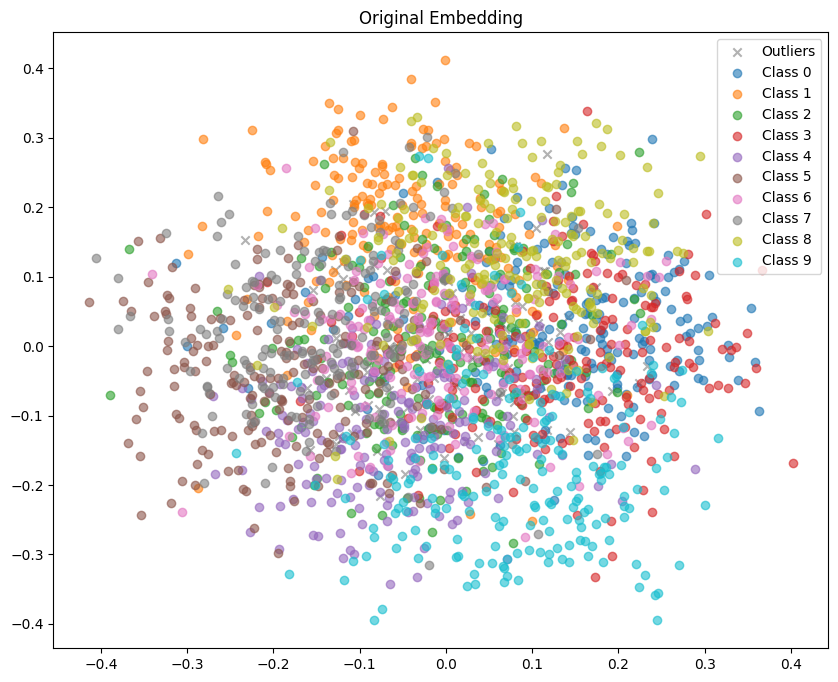

In [2]:
loaded_tensors = torch.load('synthesis_toydata.pt')
data, labels = loaded_tensors['data'], loaded_tensors['label'] 
visualize_data_PCA(data, labels, "Original Embedding")


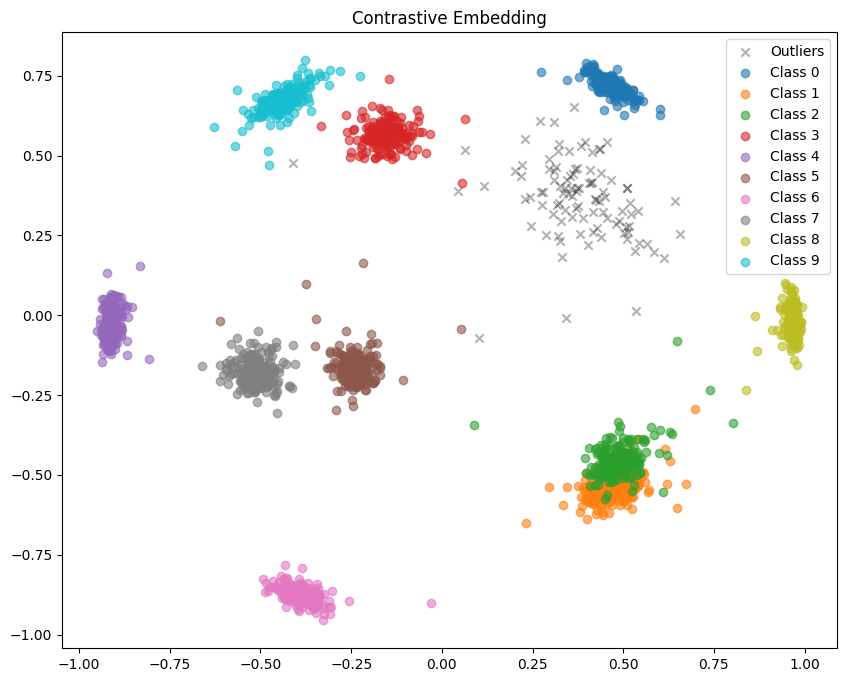

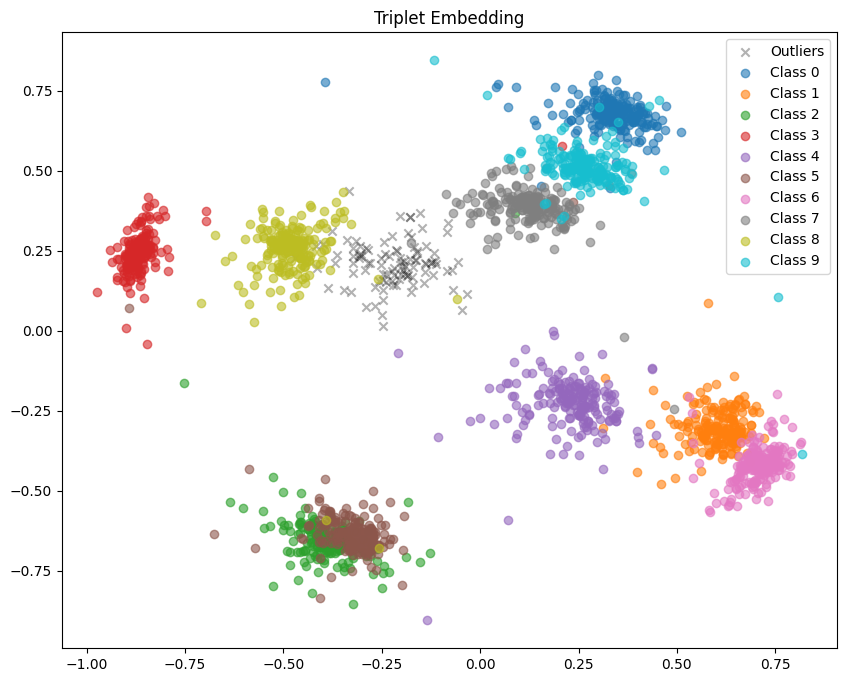

In [3]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=128, embed_dim=32):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, embed_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.normalize(self.fc2(x), dim=-1)


def train_embedding_model(data, labels, loss_type='triplet', epochs=100, batch_size=64):
    model = SimpleMLP(input_dim=data.size(1)).train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    n = len(data)

    for epoch in range(epochs):
        perm = torch.randperm(n)
        for i in range(0, n, batch_size):
            batch_idx = perm[i:i + batch_size]
            x_batch, y_batch = data[batch_idx], labels[batch_idx]
            x_embed = model(x_batch)

            optimizer.zero_grad()
            if loss_type == 'triplet':
                anchors, positives, negatives = [], [], []
                for j in range(len(x_batch)):
                    label = y_batch[j].item()
                    pos_idx = (labels == label).nonzero(as_tuple=True)[0]
                    neg_idx = (labels != label).nonzero(as_tuple=True)[0]
                    if len(pos_idx) < 2: continue

                    anchors.append(x_embed[j])
                    positives.append(model(data[random.choice(pos_idx)]))
                    negatives.append(model(data[random.choice(neg_idx)]))

                if anchors:
                    loss = triplet_loss(torch.stack(anchors), torch.stack(positives), torch.stack(negatives))
                    loss.backward()
                    optimizer.step()

            elif loss_type == 'contrastive':
                a, b, l = [], [], []
                for j in range(len(x_batch)):
                    label = y_batch[j].item()
                    if random.random() < 0.5:  # positive
                        pos_idx = (labels == label).nonzero(as_tuple=True)[0]
                        if len(pos_idx) < 2: continue
                        k = random.choice(pos_idx)
                        a.append(x_embed[j])
                        b.append(model(data[k]))
                        l.append(1.0)
                    else:  # negative
                        neg_idx = (labels != label).nonzero(as_tuple=True)[0]
                        k = random.choice(neg_idx)
                        a.append(x_embed[j])
                        b.append(model(data[k]))
                        l.append(0.0)

                if a:
                    loss = contrastive_loss(torch.stack(a), torch.stack(b), torch.tensor(l))
                    loss.backward()
                    optimizer.step()

    return model

 
model_con = train_embedding_model(data, labels, loss_type='contrastive')
data_c = model_con(data).detach() 
visualize_data_PCA(data_c, labels, "Contrastive Embedding")

model_tri = train_embedding_model(data, labels, loss_type='triplet')
data_t = model_tri(data).detach() 
visualize_data_PCA(data_t, labels, "Triplet Embedding")


In [5]:
from metric import compute_intra_class_variance, compute_inter_class_variance

variances_original = compute_intra_class_variance(data, labels)
print(variances_original)

embeddings_contrastive = model_con(data).detach()
variances_contrastive = compute_intra_class_variance(embeddings_contrastive, labels)
print(variances_contrastive)

embeddings_triplet = model_tri(data).detach()
variances_triplet = compute_intra_class_variance(embeddings_triplet, labels)
print(variances_triplet)


{-1: 0.9882476329803467, 0: 0.9237884879112244, 1: 0.9165100455284119, 2: 0.9416375756263733, 3: 0.9204889535903931, 4: 0.9171757102012634, 5: 0.9049805402755737, 6: 0.9293079376220703, 7: 0.8993827700614929, 8: 0.9179025292396545, 9: 0.9288407564163208}
{-1: 0.04708598181605339, 0: 0.005796174053102732, 1: 0.009392717853188515, 2: 0.011190018616616726, 3: 0.009755893610417843, 4: 0.006576716434210539, 5: 0.01054595597088337, 6: 0.007665674202144146, 7: 0.0061898683197796345, 8: 0.006686578970402479, 9: 0.008906347677111626}
{-1: 0.03028736263513565, 0: 0.030665284022688866, 1: 0.019531255587935448, 2: 0.0393218994140625, 3: 0.02798234485089779, 4: 0.03986595943570137, 5: 0.02981419302523136, 6: 0.020580509677529335, 7: 0.04714377596974373, 8: 0.03329215198755264, 9: 0.04342269152402878}


In [6]:
intra_values = list(variances_contrastive.values())
intra_mean = np.mean(intra_values)
intra_std = np.std(intra_values)
print(f"Intra-class variance - Mean (contrastive): {intra_mean:.4f}, Std: {intra_std:.4f}")
intra_values = list(variances_triplet.values())
intra_mean = np.mean(intra_values)
intra_std = np.std(intra_values)
print(f"Intra-class variance - Mean (triplet): {intra_mean:.4f}, Std: {intra_std:.4f}")

Intra-class variance - Mean (contrastive): 0.0118, Std: 0.0113
Intra-class variance - Mean (triplet): 0.0329, Std: 0.0084


In [7]:
inter_mean, inter_std = compute_inter_class_variance(embeddings_contrastive, labels)
print(f"Inter-class variance - Mean (Contrastive): {inter_mean:.4f}, Std: {inter_std:.4f}")
inter_mean, inter_std = compute_inter_class_variance(embeddings_triplet, labels)
print(f"Inter-class variance - Mean (Triplet): {inter_mean:.4f}, Std: {inter_std:.4f}")


Inter-class variance - Mean (Contrastive): 1.2611, Std: 0.3073
Inter-class variance - Mean (Triplet): 1.4418, Std: 0.1992
